In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import torch
from training.autoencoder import ENCODER, AUTOENCODER

ENCODER.cuda()
model = torch.load('first_modelencoder')
ENCODER.load_state_dict(model)

AUTOENCODER.cuda()
model = torch.load('first_model')
AUTOENCODER.load_state_dict(model)

C:\Users\akoos\AppData\Local\Temp\ipykernel_33300\4051600768.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('first_modelencoder')
C:\Users\akoos\AppD

<All keys matched successfully>

In [309]:
from torch.utils.data import DataLoader
from training.train import DDMDatasets

dataset_path = '../data/train_label/20220601.npy'
d = DDMDatasets(dataset_path)

train_loader = DataLoader(dataset=d,
                          batch_size=256,
                          num_workers=0,
                          shuffle=True)

Loading dataset from ../data/train_label/20220601.npy
Done loading dataset from ../data/train_label/20220601.npy (0.10s)


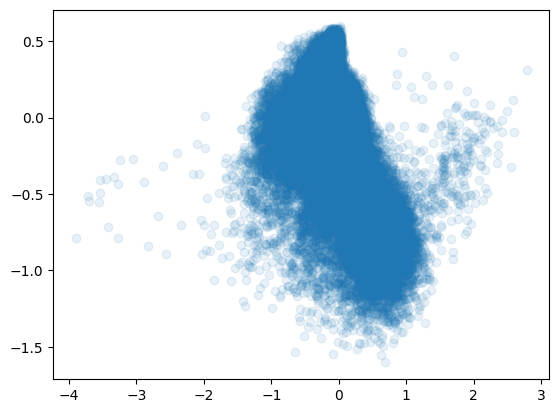

In [45]:
latent_spaces = []
for features in train_loader:
    latent_spaces += ENCODER(features).tolist()
plt.scatter(*zip(*latent_spaces), alpha=0.1)

In [13]:
import numpy as np

data = np.load(dataset_path)
ddms = data[:,data.shape[1]-(17*11):]
maxes = np.amax(ddms, axis=1).reshape(len(ddms), 1)
mines = np.amin(ddms, axis=1).reshape(len(ddms), 1)
normalized_ddms = (ddms - mines) / (maxes - mines)

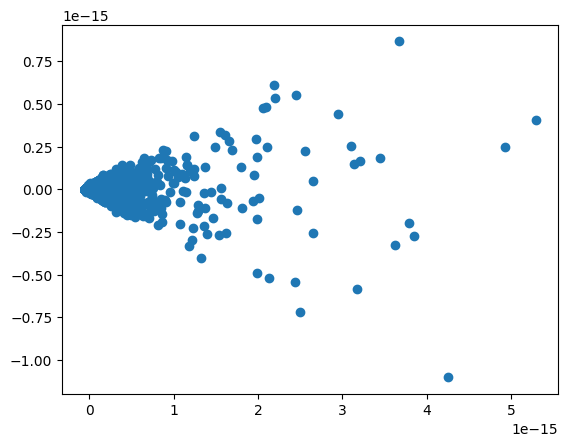

In [5]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Adjust the number of components as needed
features = pca.fit_transform(ddms)
plt.scatter(*zip(*features))

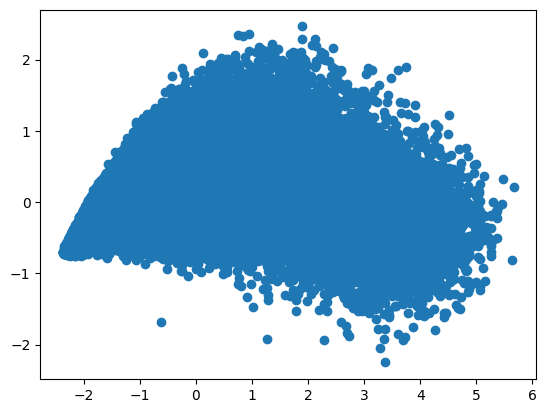

In [14]:
pca = PCA(n_components=2)  # Adjust the number of components as needed
features = pca.fit_transform(normalized_ddms)
plt.scatter(*zip(*features))

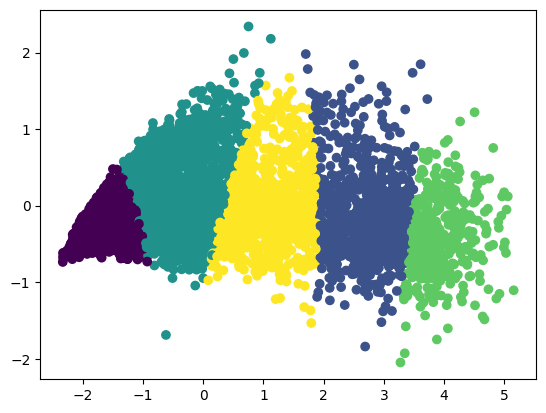

In [310]:
from sklearn.cluster import SpectralClustering, KMeans

# Apply spectral clustering
pca = PCA(n_components=2)
n_clusters = 2  # Assuming 2 clusters: coherent and incoherent
spectral = SpectralClustering(n_clusters=5)
features = pca.fit_transform(normalized_ddms)[:5000]
labels = spectral.fit_predict(features)
plt.scatter(*zip(*features), c=labels)

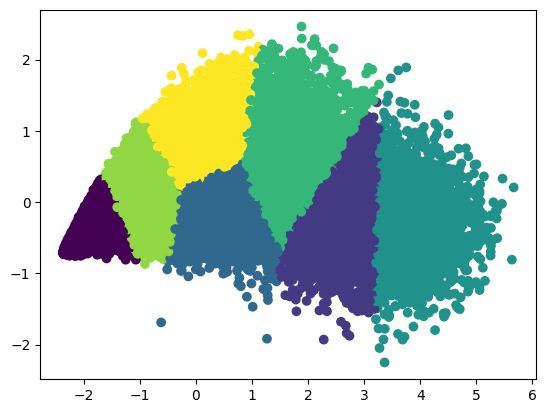

In [81]:

# Apply spectral clustering
pca = PCA(n_components=2)
n_clusters = 2  # Assuming 2 clusters: coherent and incoherent
spectral = KMeans(n_clusters=7)
features = pca.fit_transform(normalized_ddms)
labels = spectral.fit_predict(features)
plt.scatter(*zip(*features), c=labels)

In [25]:
from PIL import Image

arr = normalized_ddms[10].reshape((17,11))
im = Image.fromarray(arr * 255)
im.show()

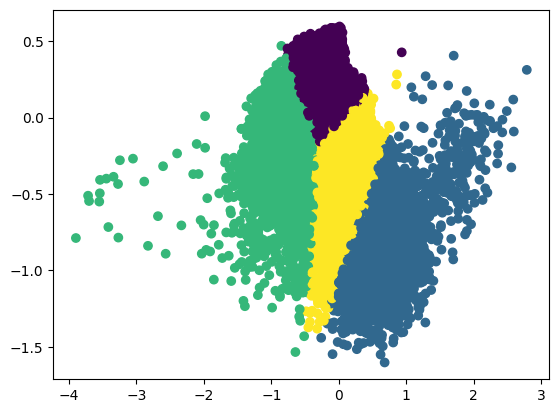

In [58]:
# Apply spectral clustering
pca = PCA(n_components=2)
n_clusters = 2  # Assuming 2 clusters: coherent and incoherent
spectral = KMeans(n_clusters=4)
features = latent_spaces
labels = spectral.fit_predict(features)
plt.scatter(*zip(*features), c=labels)

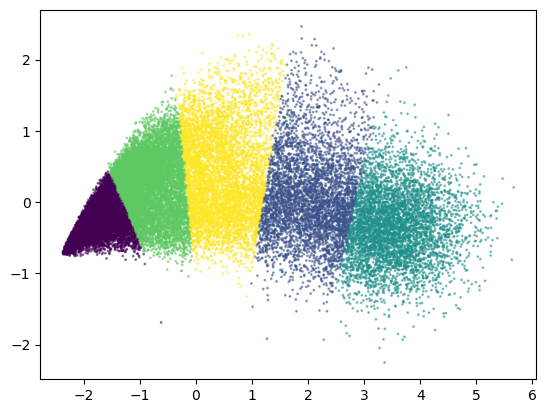

In [333]:
pca_n_components = None
n_clusters = 5
cluster_model = KMeans(n_clusters=n_clusters)
features = PCA(n_components=10).fit_transform(normalized_ddms) if pca_n_components is not None else normalized_ddms
cluster_model.fit(features)
labels = cluster_model.fit_predict(features)
plt.scatter(*zip(*pca_2.fit_transform(normalized_ddms)), c=labels, s=1, alpha=0.5)

In [ ]:
pca_2 = PCA(n_components=2)
pca_2.fit(normalized_ddms)

In [334]:
from sklearn.metrics import pairwise_distances_argmin_min

closests, _ = pairwise_distances_argmin_min(cluster_model.cluster_centers_, features)
label_mapping = {k: i for i, k in enumerate(np.argsort(pca_2.transform(normalized_ddms[closests])[:,0]))}
label_mapping_reverse = {v: k for k,v in label_mapping.items()}

In [335]:
def concatenate_images(images, direction='horizontal'):

    # Calculate the total size of the concatenated image
    if direction == 'horizontal':
        # Width is the sum of all widths, height is the max height
        total_width = sum(image.width for image in images)
        max_height = max(image.height for image in images)
        concatenated_image = Image.new('RGB', (total_width, max_height))
        
        # Paste images one by one
        x_offset = 0
        for image in images:
            concatenated_image.paste(image, (x_offset, 0))
            x_offset += image.width

    elif direction == 'vertical':
        # Width is the max width, height is the sum of all heights
        max_width = max(image.width for image in images)
        total_height = sum(image.height for image in images)
        concatenated_image = Image.new('RGB', (max_width, total_height))
        
        # Paste images one by one
        y_offset = 0
        for image in images:
            concatenated_image.paste(image, (0, y_offset))
            y_offset += image.height

    # Save the concatenated image
    return concatenated_image


In [336]:
def resize_image_by_duplicating_pixels(original_image):
    # Get original dimensions
    original_width, original_height = original_image.size

    # Calculate new dimensions (twice the size)
    new_width = original_width * 2
    new_height = original_height * 2

    # Create a new image with the new dimensions
    resized_image = Image.new('RGB', (new_width, new_height))
    
    # Load pixel data
    original_pixels = original_image.load()
    resized_pixels = resized_image.load()

    # Duplicate each pixel into a 2x2 block
    for y in range(original_height):
        for x in range(original_width):
            pixel = original_pixels[x, y]
            
            # Set the corresponding 2x2 block in the new image
            resized_pixels[2*x, 2*y] = pixel
            resized_pixels[2*x+1, 2*y] = pixel
            resized_pixels[2*x, 2*y+1] = pixel
            resized_pixels[2*x+1, 2*y+1] = pixel
    return resized_image

In [337]:
def resize_image_by_x_pixels(original_image, factor):
    # Get original dimensions
    original_width, original_height = original_image.size

    # Calculate new dimensions (twice the size)
    new_width = original_width * factor
    new_height = original_height * factor

    # Create a new image with the new dimensions
    resized_image = Image.new('RGB', (new_width, new_height))
    
    # Load pixel data
    original_pixels = original_image.load()
    resized_pixels = resized_image.load()

    # Duplicate each pixel into a 2x2 block
    for y in range(original_height):
        for x in range(original_width):
            pixel = original_pixels[x, y]
            for _y in range(factor*y, factor*y + factor):
                for  _x in range(factor*x, factor*x + factor):
                    resized_pixels[_x, _y] = pixel
            # Set the corresponding 2x2 block in the new image
            # resized_pixels[2*x, 2*y] = pixel
            # resized_pixels[2*x+1, 2*y] = pixel
            # resized_pixels[2*x, 2*y+1] = pixel
            # resized_pixels[2*x+1, 2*y+1] = pixel
    return resized_image

In [338]:
from random import sample
from PIL import ImageOps
from collections import defaultdict
import os
folder = f'../data/contact'
os.makedirs(folder, exist_ok=True)
filename = f'cluster_{n_clusters}_pca_{pca_n_components}.bmp'
cm = plt.get_cmap('viridis')
row_per_label = 10
nb_of_col = 75

label_list_image = defaultdict(list)
for i in range(len(labels)):
    label = label_mapping[labels[i]]
    arr = normalized_ddms[i].reshape((17,11))
    im = np.array(arr)
    im = cm(im)
    im = np.uint8(im * 255)
    im = Image.fromarray(im) #.resize((17*10,11*10),resample=Image.NEAREST)
    im = ImageOps.expand(im,border=1,fill='white')
    label_list_image[label].append(im)

list_image = []

for label in range(len(label_list_image)):
    selected_images = sample(label_list_image[label], row_per_label * nb_of_col)
    tmp_list = []
    for i in range(row_per_label):
        tmp_list.append(concatenate_images(selected_images[nb_of_col*i: nb_of_col * (i + 1)]))
    concat_image = concatenate_images(tmp_list, 'vertical')
    concat_image = ImageOps.expand(concat_image,border=1,fill='black')
    list_image.append(concat_image)
samples_images = concatenate_images(list_image, 'vertical')

if pca_n_components is None:
    centers_images = []
    for i in range(len(label_mapping_reverse)):
        center = cluster_model.cluster_centers_[label_mapping_reverse[i]]
        arr = center.reshape((17,11))
        im = np.array(arr)
        im = cm(im)
        im = np.uint8(im * 255)
        im = Image.fromarray(im)
        im = resize_image_by_x_pixels(im, row_per_label)
        im = ImageOps.expand(im,border=row_per_label,fill='white')
        im = ImageOps.expand(im,border=1,fill='black')
        centers_images.append(im)
    centers_image = concatenate_images(centers_images, 'vertical')

closest_images = []
for i in range(len(label_mapping_reverse)):
    closest = normalized_ddms[closests[label_mapping_reverse[i]]]
    arr = closest.reshape((17,11))
    im = np.array(arr)
    im = cm(im)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)
    im = resize_image_by_x_pixels(im, row_per_label)
    im = ImageOps.expand(im,border=row_per_label,fill='white')
    im = ImageOps.expand(im,border=1,fill='black')
    closest_images.append(im)
closest_image = concatenate_images(closest_images, 'vertical')

images = [centers_image, closest_image, samples_images] if pca_n_components is None else [closest_image, samples_images]
concatenate_images(images).save(f'{folder}/{filename}')

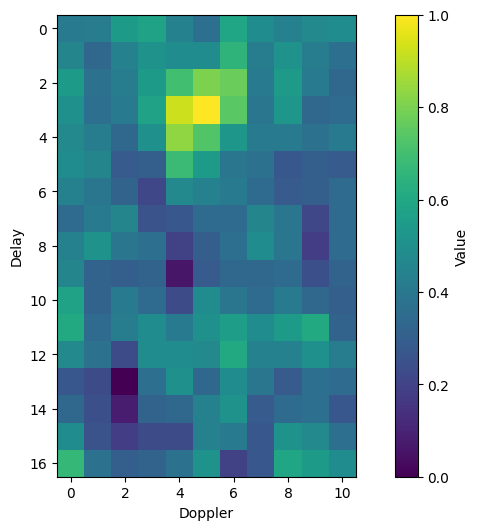

In [264]:
idx = 31687
reshaped_data = d[idx].detach().cpu().numpy().reshape((17,11)) 

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(reshaped_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Value')
plt.xlabel('Doppler')
plt.ylabel('Delay')
plt.show()

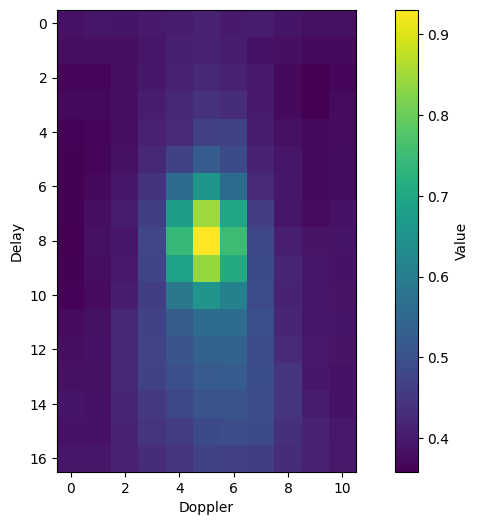

In [92]:

from training.autoencoder import Reshape

reshape = Reshape([1,1,17,11])
reshaped_data = AUTOENCODER(reshape(d[idx])).detach().cpu().numpy().reshape((17,11))

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(reshaped_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Value')
plt.xlabel('Doppler')
plt.ylabel('Delay')
plt.show()